<a href="https://colab.research.google.com/github/claudio-toledo/NeuralStyleTransfer/blob/main/Neural%20Style%20Transfer%20v1.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI Generating Art: Neural Style Transfer

Wouldn't be amazing if we could ask, at any time, any famous painter, to paint whatever we would like them to? 

Working in the art materials industry and as an AI passionate, I caught myself thinking about what AI can do in this sector to challenge the status quo and how it will empower artists to achieve more, in any part of the world.

Art is so human-centric that I really don't think it will be seen as a replacement but rather, it will help on artists' thinking and serve as a augment tool to inspire them to express themselves.

Neural style transfer is a technique within Deep Learning that uses two images —a content image and a style reference image (such as a stylized image from a famous painter)—applying a learning algorithm that learns the style from the image to apply in the content — still keeping key elements from the source of the image. This algorithm was created by Gatys et al. (2015) (https://arxiv.org/abs/1508.06576).

### Link to my LinkedIn Article: https://www.linkedin.com/post/edit/6726605224368312320/

## Importing the modules and initial setup

In [1]:
import IPython.display as display
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

## Creating the helper functions

In [2]:
#return a tesnor to an image as a tensor for the tensorflo algorithm
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

#Function to load an image from a path
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

# displaying an image
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

### Setting up the content image and style image

The algorithm consists in merging two images: 1) content image and 2) content image. Based on these two, we will generate the third image, combining elements from the content with the style image.

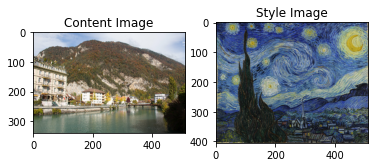

In [3]:
#Loding and displaying the image

content_path = 'content3.jpg'
style_path = 'style1.jpeg'

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

### Transfer learning from VGG19
As it suggests in the original paper from Gatys et al, the way the algorithm works is by using a model pre-trained on a large image data set. The intermediate layers of this pre-trained model work like feature detectors. Specifically, we'll use VGG-19, a 19-layer version of the VGG network. This model has already been trained on the very large ImageNet database, and thus has learned to recognize a variety of low-level features (at the earlier layers) and high-level features (at the deeper layers).

In [4]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574717952/574710816 [==============================] - 3s 0us/step


TensorShape([1, 1000])

In [5]:
#checking already some predictions on the content image to see if it's too shallow or too deep
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

40960/35363 [==================================] - 0s 0us/step


[('lakeside', 0.6922615),
 ('boathouse', 0.14744145),
 ('dock', 0.022559986),
 ('seashore', 0.021333367),
 ('palace', 0.01893443)]

In [6]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')


80142336/80134624 [==============================] - 1s 0us/step


In [7]:
# We will arbitraly select layers to apply in the content and to style image

content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    # Load our model. Load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [9]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()

block1_conv1
  shape:  (1, 405, 512, 64)
  min:  0.0
  max:  672.0438
  mean:  23.748146

block2_conv1
  shape:  (1, 202, 256, 128)
  min:  0.0
  max:  2859.4375
  mean:  146.61075

block3_conv1
  shape:  (1, 101, 128, 256)
  min:  0.0
  max:  7283.5654
  mean:  141.08168

block4_conv1
  shape:  (1, 50, 64, 512)
  min:  0.0
  max:  16384.785
  mean:  554.75525

block5_conv1
  shape:  (1, 25, 32, 512)
  min:  0.0
  max:  3961.5244
  mean:  47.41307



### Gram Matrix

The style matrix is also called a "Gram matrix." In linear algebra, the Gram matrix G of a set of vectors is the matrix of dot products, whose entries are. In other words,  compares how similar is to: If they are highly similar, you would expect them to have a large dot product, and thus for to be large.

The content of an image is represented by the values of the intermediate feature maps.

It turns out, the style of an image can be described by the means and correlations across the different feature maps. Calculate a Gram matrix that includes this information by taking the outer product of the feature vector with itself at each location, and averaging that outer product over all locations. This Gram matrix can be calculated for a particular layer as:

This can be implemented concisely using the tf.linalg.einsum function:



In NST, you can compute the Style matrix by multiplying the "unrolled" filter matrix with their transpose:

In [10]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

In [11]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

In [12]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()

print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.14654142
    max:  31019.168
    mean:  494.92007

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  162136.8
    mean:  17989.164

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  262575.8
    mean:  14663.1455

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  5293289.5
    mean:  221645.52

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  104493.6
    mean:  1768.0758

Contents:
   block5_conv2
    shape:  (1, 21, 31, 512)
    min:  0.0
    max:  979.47504
    mean:  14.734717


In [13]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [14]:
image = tf.Variable(content_image)

In [15]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [16]:
#Using the Adm as optmizer with hyperparameters as shown below
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [17]:
#arbitraly selecting these parameters as indicated by the original paper.
style_weight=1e-2
content_weight=1e4

In [18]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [19]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

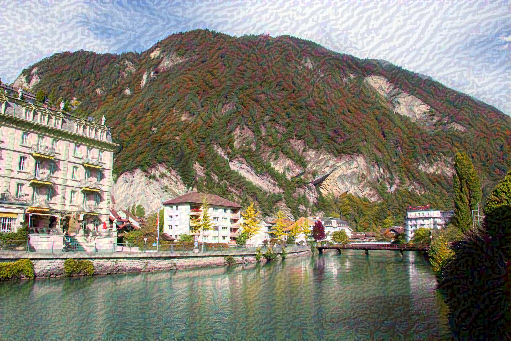

In [20]:
#Sanity check if the train steps are converging to a stylezed image to proceed further
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [21]:
# Total variation loss
# One downside to this basic implementation is that it produces a lot of high frequency artifacts. 
# Decrease these using an explicit regularization term on the high frequency components of the image. 
# In style transfer, this is often called the total variation loss:
def high_pass_x_y(image):
    x_var = image[:,:,1:,:] - image[:,:,:-1,:]
    y_var = image[:,1:,:,:] - image[:,:-1,:,:]

    return x_var, y_var

def total_variation_loss(image):
    x_deltas, y_deltas = high_pass_x_y(image)
    return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

tf.image.total_variation(image).numpy()

array([73564.61], dtype=float32)

In [22]:
total_variation_weight=30

In [23]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [24]:
image = tf.Variable(content_image)

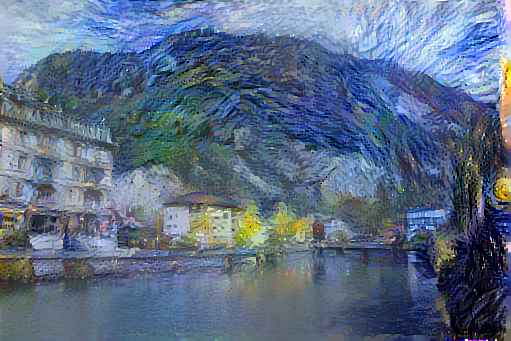

Train step: 1000
Total time: 66.1


In [25]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

## Conclusion:


Neural Style Transfer is an algorithm that given a content image C and a style image S can generate an artistic image
It uses representations (hidden layer activations) based on a pre-trained ConvNet.
The content cost function is computed using one hidden layer's activations.
The style cost function for one layer is computed using the Gram matrix of that layer's activations. The overall style cost function is obtained using several hidden layers.
Optimizing the total cost function results in synthesizing new images.

### References:
Leon A. Gatys, Alexander S. Ecker, Matthias Bethge, (2015). A Neural Algorithm of Artistic Style (https://arxiv.org/abs/1508.06576)
Harish Narayanan, Convolutional neural networks for artistic style transfer. https://harishnarayanan.org/writing/artistic-style-transfer/
Neural Style Transfer, https://www.tensorflow.org/tutorials/generative/style_transfer
Log0, TensorFlow Implementation of "A Neural Algorithm of Artistic Style". http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style
Karen Simonyan and Andrew Zisserman (2015). Very deep convolutional networks for large-scale image recognition (https://arxiv.org/pdf/1409.1556.pdf)
MatConvNet. http://www.vlfeat.org/matconvnet/pretrained/